# Outlier Detection

## Information
- dataset : https://www.kaggle.com/arunrk7/surface-crack-detection
- reference source : https://colab.research.google.com/drive/1p33BV8NpKlPrXTxDtMjPRRn6lHbL_ckS?usp=sharing#scrollTo=TMOndydm1jy3

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *

from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from alibi_detect.utils.saving import save_detector
from alibi_detect.utils.saving import load_detector

from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

D:\anaconda3\envs\outlier_detection\lib\site-packages\ipykernel\parentpoller.py:112: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
tf.__version__

'2.6.0'

In [3]:
gpus = tf.config.experimental.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Load The data

In [4]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

In [5]:
images = glob(os.path.join(DATASET_DIR, 'Negative', '*.jpg'))
print(images[:5])

['D:\\projects\\research\\outlier_detection\\datasets\\Negative\\00001.jpg', 'D:\\projects\\research\\outlier_detection\\datasets\\Negative\\00002.jpg', 'D:\\projects\\research\\outlier_detection\\datasets\\Negative\\00003.jpg', 'D:\\projects\\research\\outlier_detection\\datasets\\Negative\\00004.jpg', 'D:\\projects\\research\\outlier_detection\\datasets\\Negative\\00005.jpg']


In [6]:
train_imgs, val_imgs = train_test_split(images, test_size=0.1, random_state=1234)

In [7]:
def img2numpy(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
        try:
            img = Image.open(fname).convert('RGB')
            if(resize): 
                img = img.resize((64, 64))
            img_array.append(np.asarray(img))
        except:
            continue
    images = np.array(img_array)
    return images

In [8]:
x_train = img2numpy(train_imgs)
x_train = x_train.astype(np.float32) / 255.

x_val = img2numpy(val_imgs[:100])
x_val = x_val.astype(np.float32) / 255.

In [9]:
print(x_train.shape)
print(x_val.shape)

(18000, 64, 64, 3)
(100, 64, 64, 3)


## Visualize the data

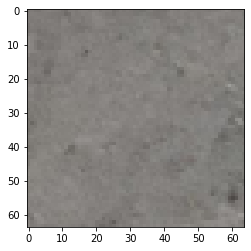

In [10]:
plt.imshow(x_train[0])

## Build Model

In [11]:
def build_model():
    latent_dim = 1024
    encoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(64, 64, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
    ])

    decoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(latent_dim,)),
        Dense(4 * 4 * 128),
        Reshape(target_shape=(4, 4, 128)),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])

    od = OutlierVAE(
        threshold=.005,
        score_type='mse',
        encoder_net=encoder_net,
        decoder_net=decoder_net,
        latent_dim=latent_dim,
    )    
    return od

In [12]:
od = build_model()

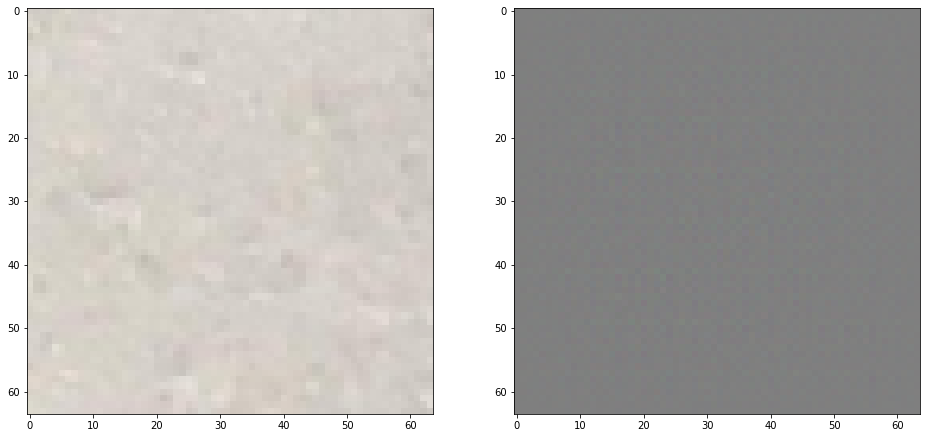

In [13]:
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

## Inference

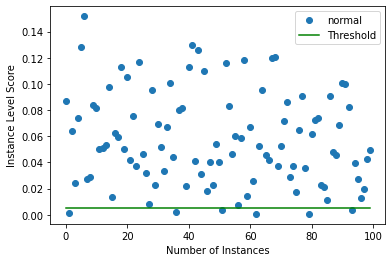

In [14]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

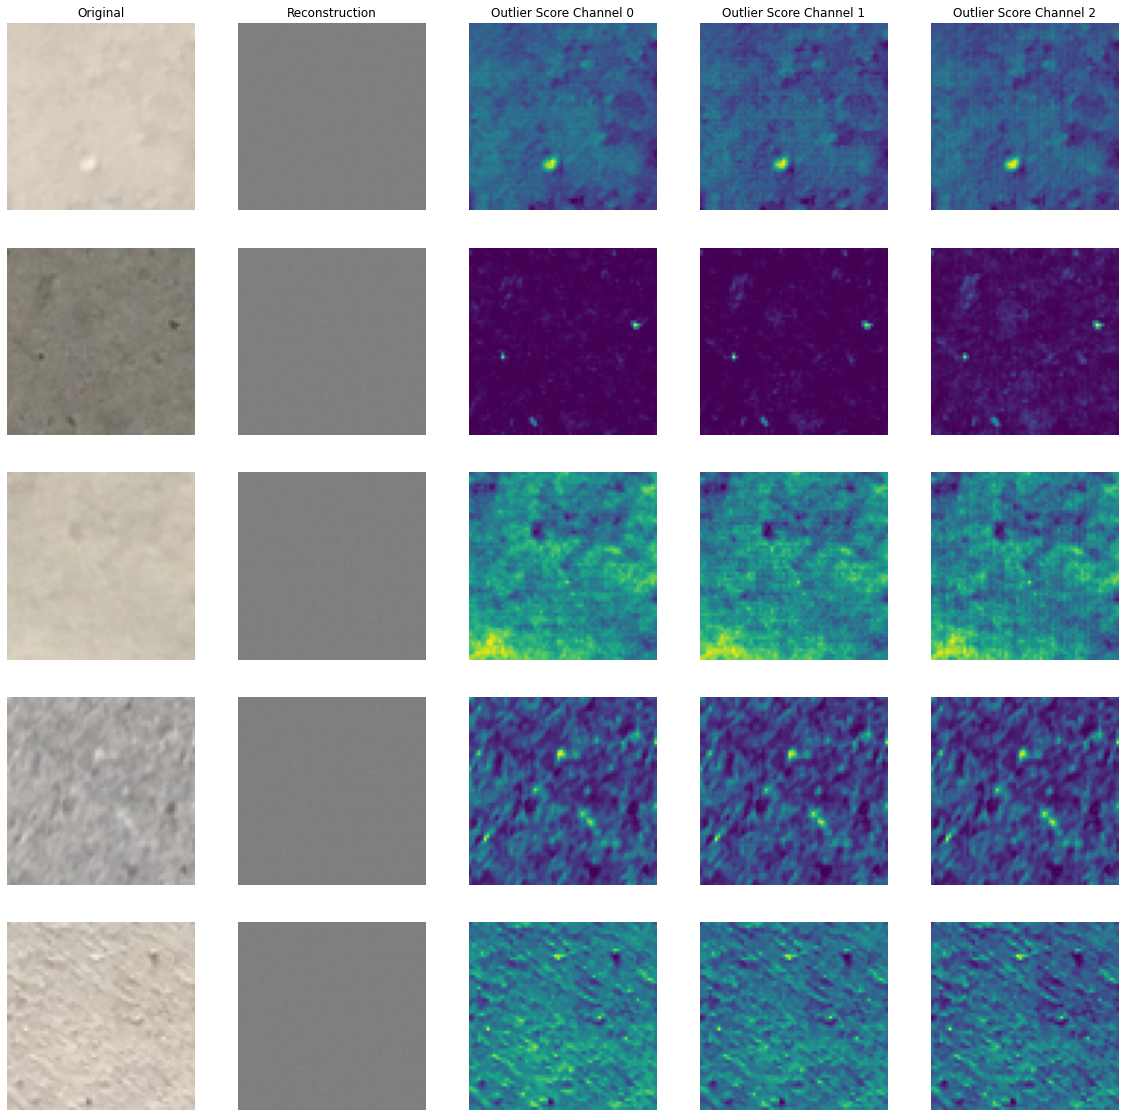

In [15]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

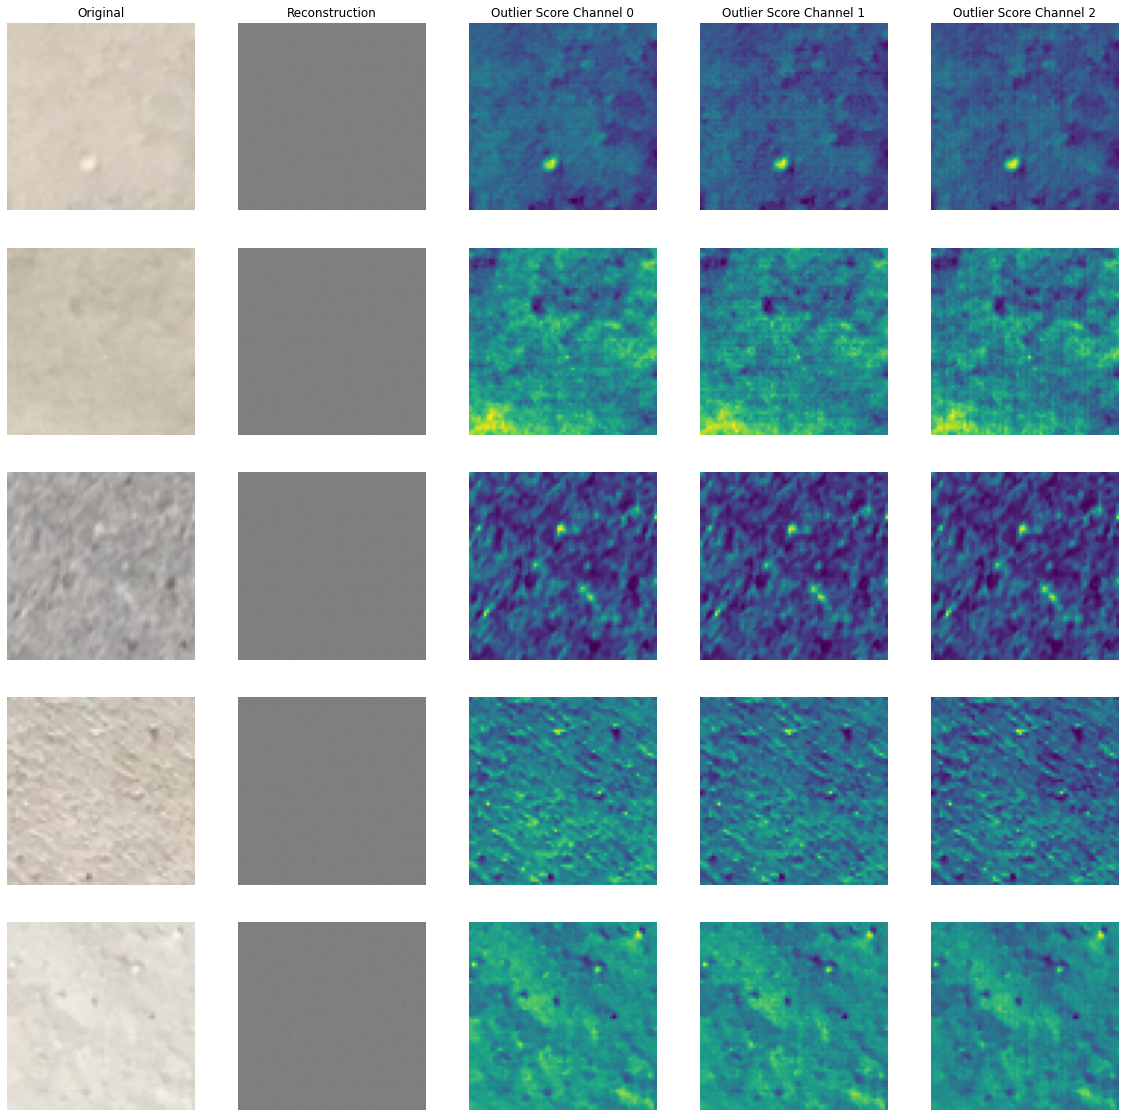

In [16]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

In [17]:
test_img_list = glob(os.path.join(DATASET_DIR, 'Positive', '*.jpg'))

x_test = img2numpy(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


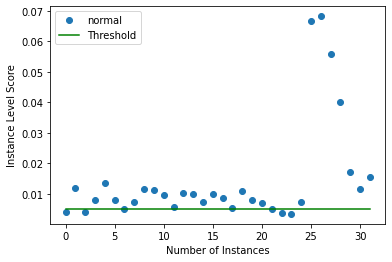

In [18]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

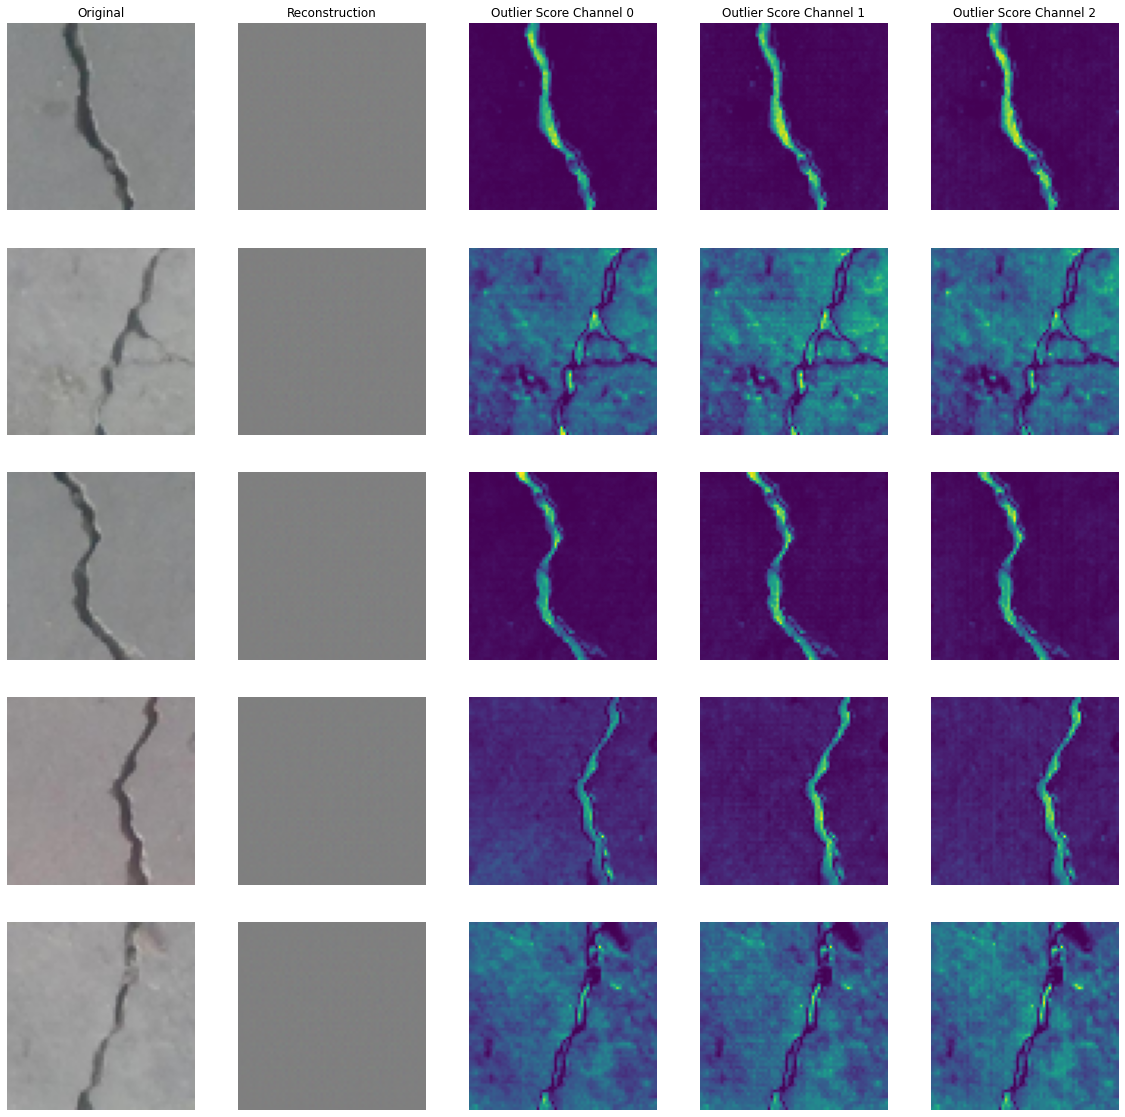

In [19]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)